In [39]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

torch.manual_seed(42)
random.seed(42)

In [40]:
target = "Median household income ($)" # "Owner-occupied [%]"

In [41]:
loaded_x = np.load("../../Data/Data/data_x_" + target + ".npz", allow_pickle=True)
dict_x = {key: loaded_x[key] for key in loaded_x.files}

loaded_y = np.load("../../Data/Data/data_y_" + target + ".npz", allow_pickle=True)
dict_y = {key: loaded_y[key] for key in loaded_y.files}

In [42]:
all_keys = list(dict_x.keys())
random.shuffle(all_keys)

split_index = int(len(all_keys) * 0.8)
train_keys = all_keys[:split_index]
valid_keys = all_keys[split_index:]

data_train_x = np.vstack([dict_x[k] for k in train_keys]) 
data_valid_x = np.vstack([dict_x[k] for k in valid_keys])
data_x = np.vstack([dict_x[k] for k in all_keys])

data_train_y = np.concatenate([dict_y[k] for k in train_keys]) 
data_valid_y = np.concatenate([dict_y[k] for k in valid_keys]) 
data_y = np.concatenate([dict_y[k] for k in all_keys])

print(data_valid_x.shape, data_valid_y.shape)
print(data_train_x.shape, data_train_y.shape)
print(data_x.shape, data_y.shape)

(7440, 3, 73) (7440,)
(29712, 3, 73) (29712,)
(37152, 3, 73) (37152,)


In [43]:
data_train_x = torch.tensor(data_train_x, dtype=torch.float32)
data_train_y = torch.tensor(data_train_y, dtype=torch.float32).unsqueeze(1)
data_valid_x = torch.tensor(data_valid_x, dtype=torch.float32)
data_valid_y = torch.tensor(data_valid_y, dtype=torch.float32).unsqueeze(1)
data_x = torch.tensor(data_x, dtype=torch.float32)
data_y = torch.tensor(data_y, dtype=torch.float32).unsqueeze(1)

In [44]:
batch_size = data_train_x.shape[0]

dataset_train = TensorDataset(data_train_x, data_train_y)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=5) 
dataset_valid = TensorDataset(data_valid_x, data_valid_y)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=5) 

In [45]:
class RNN_Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        lstm_hidden_size = 32
        hidden_size = 4

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, batch_first=True)

        self.dense1 = nn.Linear(lstm_hidden_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, output_size)

        

    def forward(self, input):
        x = F.dropout(input, p=0.35)

        x, _ = self.lstm(x)
        x = x[:, -1, :]

        x = self.dense1(x)
        x = F.leaky_relu(x)

        x = self.dense2(x)
        x = F.sigmoid(x)

        return x

In [46]:
model = RNN_Regressor(data_train_x.shape[2], 1)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)
criterion = nn.MSELoss()

history = {
    "train_loss": [],
    "valid_loss": []
}

In [ ]:
max_epochs = 200

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in dataloader_train:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    history["train_loss"].append(running_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dataloader_valid:
            val_outputs = model(x_batch)
            val_loss = criterion(val_outputs, y_batch)
            running_val_loss += val_loss.item()

    history["valid_loss"].append(running_val_loss)

    print(f"Epoch [{epoch+1}/{max_epochs}], Training Loss: {history['train_loss'][-1]:.5f}, Validation Loss: {history['valid_loss'][-1]:.5f}")


In [ ]:
#model = torch.jit.load("../Model/model_" + target + ".pt")

In [49]:
model.eval()
with torch.no_grad(): 
    output = model(data_train_x)
print(r2_score(data_train_y, output))

0.9097924752407909


In [50]:
model.eval()
with torch.no_grad(): 
    output = model(data_valid_x)
print(r2_score(data_valid_y, output))

0.921767717746671


In [51]:
model.eval()
with torch.no_grad(): 
    output = model(data_x)
print(r2_score(data_y, output))

0.9107295922437899


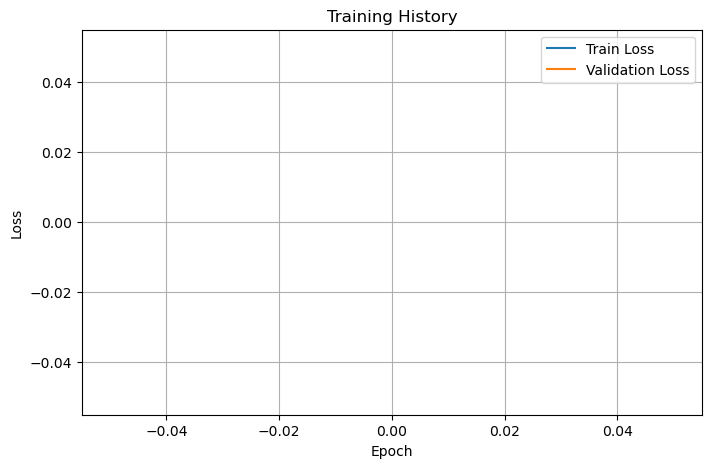

In [52]:
train_loss = history["train_loss"]
valid_loss = history["valid_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, valid_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training History")
plt.legend()
plt.grid(True)

In [ ]:
torch.jit.script(model).save("../Model/model_" + target + ".pt")